In [1]:
# General Imports
import numpy as np
from math import pi
import datetime
# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Pandas Imports
import pandas as pd

#Seaborn Imports
import seaborn as sns

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.algorithms.classifiers import VQC

from IPython.display import clear_output

In [2]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

In [3]:
def support_vector_machine(hd, list_feature, kernel, random_state = 0):
    sample_train, sample_test, label_train, label_test = train_test_split(hd[list_feature],
                                                                          hd['target'],test_size=0.3,
                                                                          random_state=random_state,
                                                                          stratify=hd['target'])
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Scale
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Select
    train_size = len(sample_train)

    label_train = label_train[:train_size].to_numpy(copy="True")

    test_size = len(sample_test)
    sample_test = sample_test[:test_size]
    label_test = label_test[:test_size].to_numpy(copy="True")

    output_svc = SVC(kernel=kernel)
    output_svc.fit(sample_train, label_train)

    return output_svc, sample_test, label_test

In [4]:
def show_metrics(data, list_feature, kernel, random_state):
    print("random state", random_state)
    print(list_feature)
    print()
    svc_output , sample_test, y_true = support_vector_machine(data, list_feature, kernel,
                                                                 random_state = random_state)
    y_pred = svc_output.predict(sample_test)
    print(classification_report(y_true, y_pred))
    y_score = svc_output.decision_function(sample_test)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label =\
     r"ROC (AUC = %0.3f )" % roc_auc_score(y_true, y_score) )

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
heart_data = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

In [6]:
heart_data.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000
mean,53.720,0.764,3.233,132.154,210.364,0.213,0.698,139.733,0.387,0.923,1.624,0.529
std,9.358,0.425,0.935,18.369,101.420,0.410,0.870,25.518,0.487,1.086,0.610,0.499
min,28.000,0.000,1.000,0.000,0.000,0.000,0.000,60.000,0.000,-2.600,0.000,0.000
25%,47.000,1.000,3.000,120.000,188.000,0.000,0.000,121.000,0.000,0.000,1.000,0.000
50%,54.000,1.000,4.000,130.000,229.000,0.000,0.000,140.500,0.000,0.600,2.000,1.000
75%,60.000,1.000,4.000,140.000,269.750,0.000,2.000,160.000,1.000,1.600,2.000,1.000
max,77.000,1.000,4.000,200.000,603.000,1.000,2.000,202.000,1.000,6.200,3.000,1.000


In [7]:
# before data correction for absurd values
heart_data.corr()
# it can be seen that cholesterol is inversely corralated with coronary artery disease!

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
age,1.000,0.015,0.149,0.258,-0.046,0.179,0.195,-0.369,0.188,0.245,0.238,0.262
sex,0.015,1.000,0.138,-0.006,-0.208,0.111,-0.022,-0.182,0.194,0.096,0.128,0.311
chest pain type,0.149,0.138,1.000,0.009,-0.109,0.076,0.036,-0.337,0.403,0.224,0.277,0.460
resting bp s,0.258,-0.006,0.009,1.000,0.099,0.088,0.096,-0.101,0.142,0.176,0.089,0.121
cholesterol,-0.046,-0.208,-0.109,0.099,1.000,-0.240,0.151,0.238,-0.033,0.057,-0.100,-0.198
fasting blood sugar,0.179,0.111,0.076,0.088,-0.240,1.000,0.032,-0.119,0.053,0.031,0.146,0.217
resting ecg,0.195,-0.022,0.036,0.096,0.151,0.032,1.000,0.059,0.038,0.126,0.094,0.073
max heart rate,-0.369,-0.182,-0.337,-0.101,0.238,-0.119,0.059,1.000,-0.378,-0.184,-0.351,-0.413
exercise angina,0.188,0.194,0.403,0.142,-0.033,0.053,0.038,-0.378,1.000,0.371,0.393,0.481
oldpeak,0.245,0.096,0.224,0.176,0.057,0.031,0.126,-0.184,0.371,1.000,0.525,0.398


In [8]:
heart_data = heart_data.rename(columns={'resting bp s': 'rs'})

# taking care of impossible 0.0 values: mean substitution
mean_trestbps = heart_data.query("rs != 0.0")['rs'].mean()
heart_data.loc[heart_data["rs"] == 0.0, "rs"] = mean_trestbps

mean_cholesterol = heart_data.query("cholesterol != 0.0")['cholesterol'].mean()
heart_data.loc[heart_data["cholesterol"] == 0.0, "cholesterol"] = mean_cholesterol

heart_data = heart_data.rename(columns={'rs': 'resting bp s'})

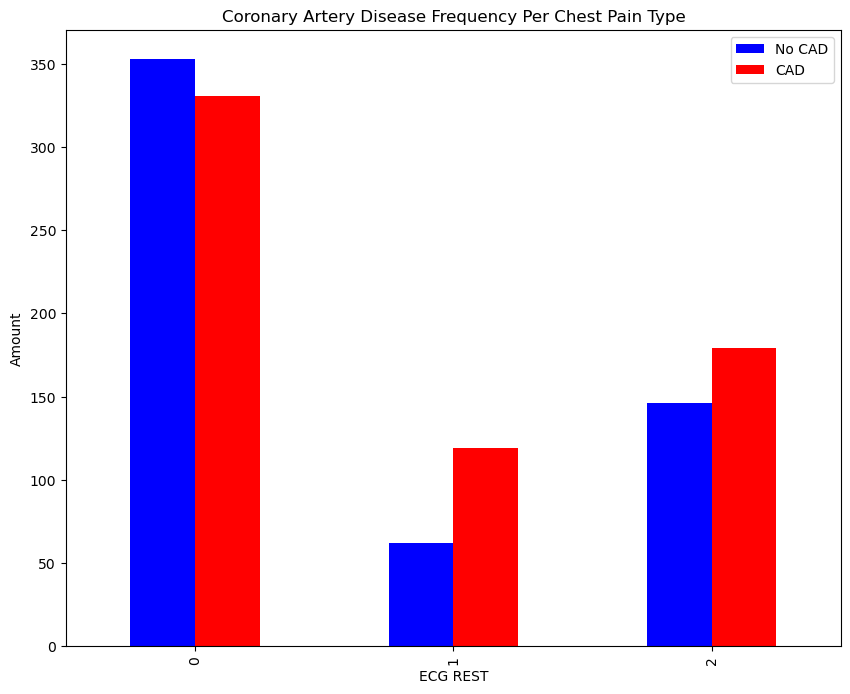

In [9]:
# analyze ECG at rest data
pd.crosstab(heart_data['resting ecg'],heart_data.target).plot(kind = 'bar',
                                        figsize = (10,8),
                                        color = ['blue','red'])
                                        
                                        

plt.title("Coronary Artery Disease Frequency Per Chest Pain Type");
plt.xlabel("ECG REST")
plt.ylabel("Amount")
plt.legend(["No CAD", "CAD"])

In [10]:
heart_data.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000
mean,53.720,0.764,3.233,132.265,245.907,0.213,0.698,139.733,0.387,0.923,1.624,0.529
std,9.358,0.425,0.935,17.964,52.942,0.410,0.870,25.518,0.487,1.086,0.610,0.499
min,28.000,0.000,1.000,80.000,85.000,0.000,0.000,60.000,0.000,-2.600,0.000,0.000
25%,47.000,1.000,3.000,120.000,214.000,0.000,0.000,121.000,0.000,0.000,1.000,0.000
50%,54.000,1.000,4.000,130.000,245.907,0.000,0.000,140.500,0.000,0.600,2.000,1.000
75%,60.000,1.000,4.000,140.000,269.750,0.000,2.000,160.000,1.000,1.600,2.000,1.000
max,77.000,1.000,4.000,200.000,603.000,1.000,2.000,202.000,1.000,6.200,3.000,1.000


In [11]:
heart_data.corr()
# now cholesterol is popsitively corralated with coronary artery disease and cardiologist are happy

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
age,1.000,0.015,0.149,0.264,0.092,0.179,0.195,-0.369,0.188,0.245,0.238,0.262
sex,0.015,1.000,0.138,-0.003,-0.127,0.111,-0.022,-0.182,0.194,0.096,0.128,0.311
chest pain type,0.149,0.138,1.000,0.008,0.078,0.076,0.036,-0.337,0.403,0.224,0.277,0.460
resting bp s,0.264,-0.003,0.008,1.000,0.101,0.087,0.093,-0.100,0.141,0.183,0.095,0.130
cholesterol,0.092,-0.127,0.078,0.101,1.000,0.039,0.096,-0.011,0.075,0.050,0.055,0.098
fasting blood sugar,0.179,0.111,0.076,0.087,0.039,1.000,0.032,-0.119,0.053,0.031,0.146,0.217
resting ecg,0.195,-0.022,0.036,0.093,0.096,0.032,1.000,0.059,0.038,0.126,0.094,0.073
max heart rate,-0.369,-0.182,-0.337,-0.100,-0.011,-0.119,0.059,1.000,-0.378,-0.184,-0.351,-0.413
exercise angina,0.188,0.194,0.403,0.141,0.075,0.053,0.038,-0.378,1.000,0.371,0.393,0.481
oldpeak,0.245,0.096,0.224,0.183,0.050,0.031,0.126,-0.184,0.371,1.000,0.525,0.398


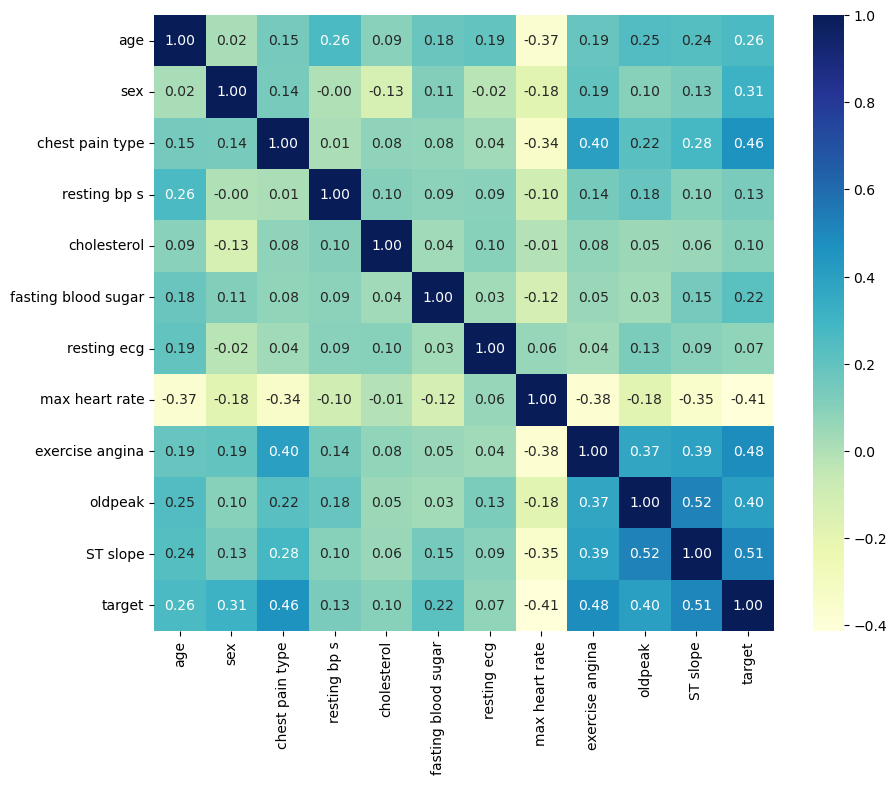

In [12]:
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.heatmap(heart_data.corr(),
                annot = True,
                fmt = ".2f",
                cmap = 'YlGnBu')

## Receiver Operating Characteristic (ROC) with cross validation

inspired by:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [15]:
def cross_val(data_frame, feature_list, condition, kernel, method , random_state = None, n_splits = 10):
    X = heart_data[feature_list].to_numpy()
    y = heart_data[condition].to_numpy()
    
    cv = StratifiedKFold(n_splits=n_splits)
    classifier = SVC(kernel=kernel, probability=True, random_state=random_state)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        print("fold", fold, "starting")
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label: coronary artey disease - Method :"+method+")",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

fold 0 starting
fold 1 starting
fold 2 starting
fold 3 starting
fold 4 starting


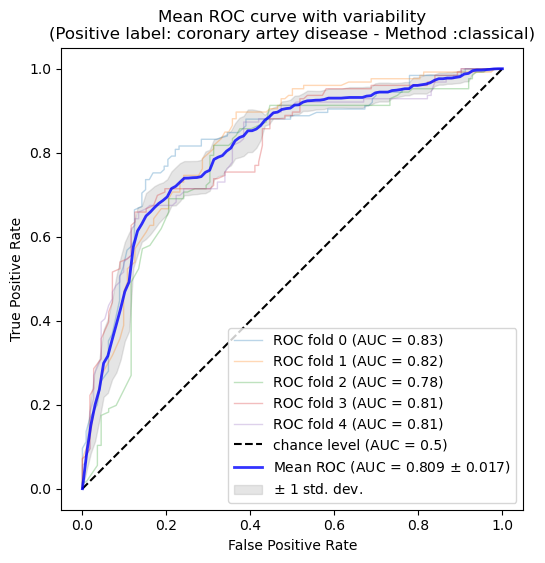

In [16]:
# check the function and plot design
list_feature =  ['age', 'sex', 'chest pain type']  
cross_val(heart_data, list_feature, 'target', kernel = "linear", method = "classical", random_state = None, n_splits = 5)

In [72]:
list_feature =  ['age', 'sex', 'chest pain type','resting bp s','cholesterol','fasting blood sugar',
                 'resting ecg','max heart rate','exercise angina', 'oldpeak', 'ST slope']      

12:54
fold 0 starting
fold 1 starting
fold 2 starting
fold 3 starting
fold 4 starting
fold 5 starting
fold 6 starting
fold 7 starting
fold 8 starting
fold 9 starting


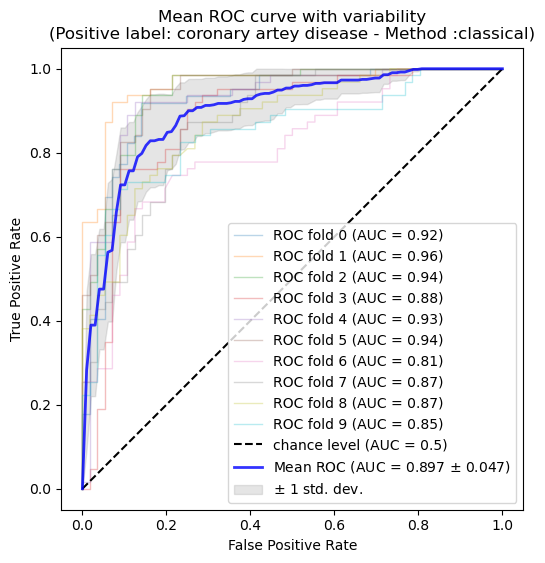

12:57


In [20]:
print(datetime.datetime.now().strftime("%H:%M"))
cross_val(heart_data, list_feature, 'target', kernel = "linear", method = "classical",
          random_state = None, n_splits = 10)
print(datetime.datetime.now().strftime("%H:%M"))

##  4-qubit feature map for 11 features

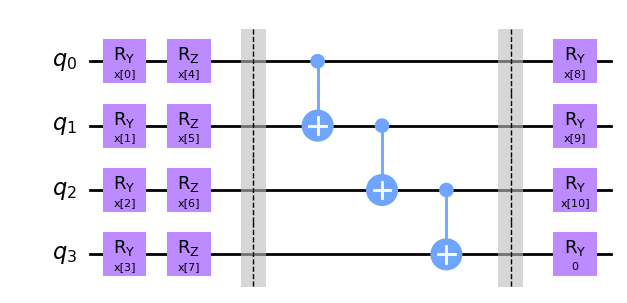

In [13]:
p1 = ParameterVector('x', 11)  
feature_map = QuantumCircuit(4)
for i in range(4):
    feature_map.ry(p1[i],i)
for i in range(4):
    feature_map.rz(p1[i+4],i)
feature_map.barrier()
for i in range(3):
    feature_map.cx(i,i+1)
feature_map.barrier()
for i in range(3):
    feature_map.ry(p1[i+8],i)
feature_map.ry(0,3)
feature_map.draw(output="mpl")

In [42]:
zz_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('statevector_simulator'))

12:57
fold 0 starting
fold 1 starting
fold 2 starting
fold 3 starting
fold 4 starting
fold 5 starting
fold 6 starting
fold 7 starting
fold 8 starting
fold 9 starting


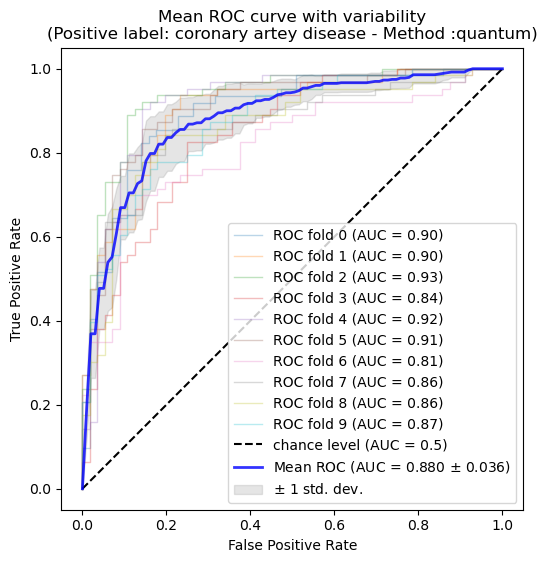

13:06


In [21]:
print(datetime.datetime.now().strftime("%H:%M"))
cross_val(heart_data, list_feature, 'target', kernel = zz_kernel.evaluate,
          method = "quantum", random_state = None, n_splits = 10)
print(datetime.datetime.now().strftime("%H:%M"))

 ## Corrected for ECG at rest

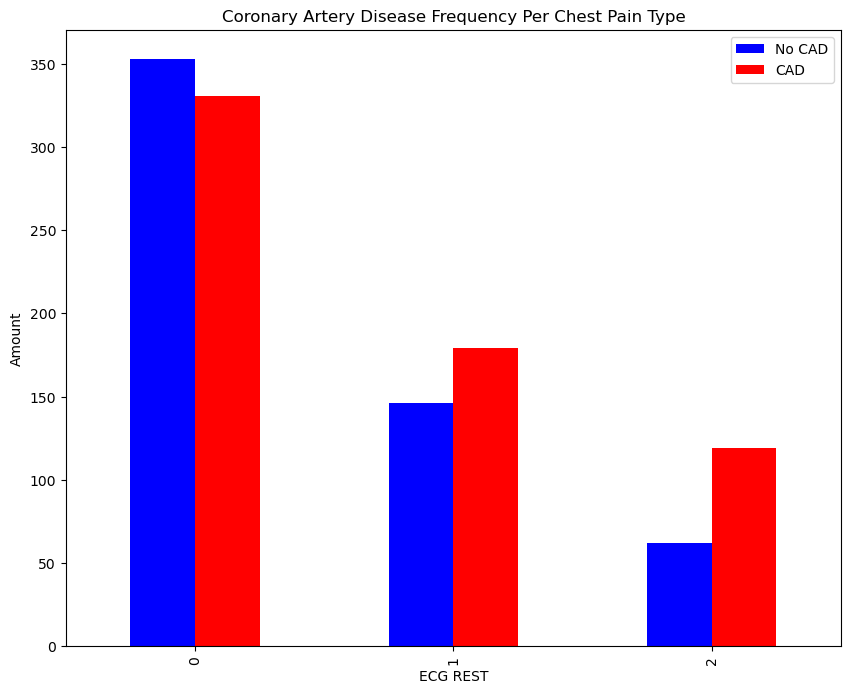

In [27]:
# correction
heart_data.loc[heart_data["resting ecg"] == 2.0, "resting ecg"] = 3.0
heart_data.loc[heart_data["resting ecg"] == 1.0, "resting ecg"] = 2.0
heart_data.loc[heart_data["resting ecg"] == 3.0, "resting ecg"] = 1.0
# check: analyze ECG at rest data
pd.crosstab(heart_data['resting ecg'],heart_data.target).plot(kind = 'bar',
                                        figsize = (10,8),
                                        color = ['blue','red'])
                                        
plt.title("Coronary Artery Disease Frequency Per Chest Pain Type");
plt.xlabel("ECG REST")
plt.ylabel("Amount")
plt.legend(["No CAD", "CAD"])

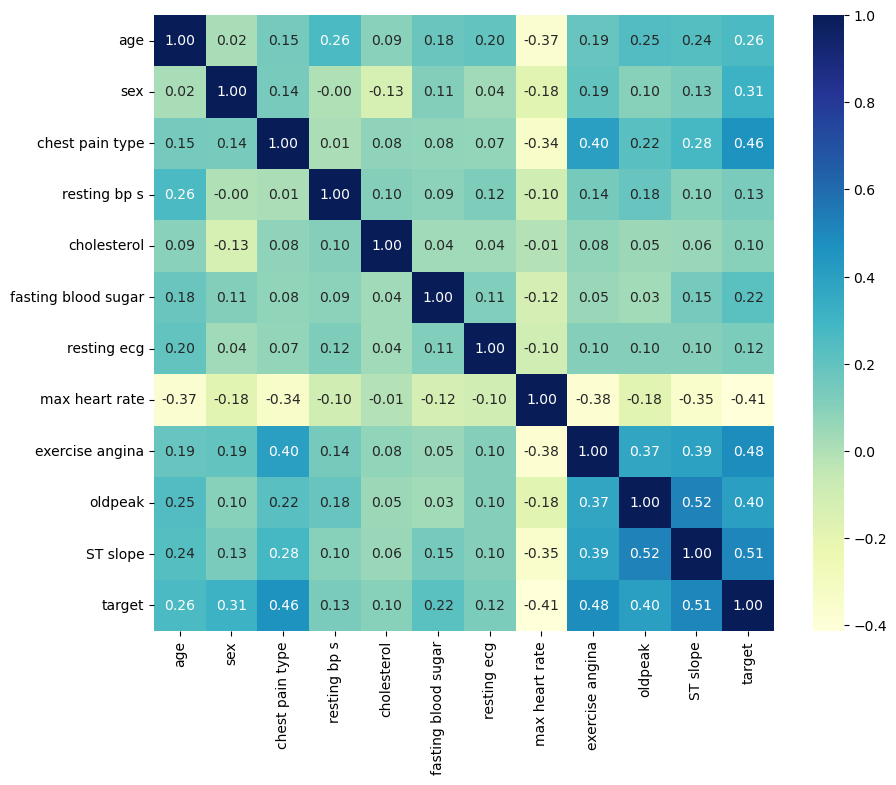

In [28]:
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.heatmap(heart_data.corr(),
                annot = True,
                fmt = ".2f",
                cmap = 'YlGnBu')

##  redo classical

13:44
fold 0 starting
fold 1 starting
fold 2 starting
fold 3 starting
fold 4 starting
fold 5 starting
fold 6 starting
fold 7 starting
fold 8 starting
fold 9 starting


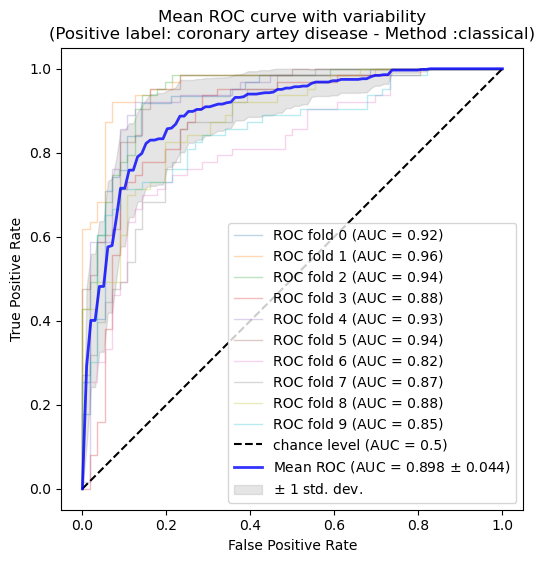

13:47


In [29]:
print(datetime.datetime.now().strftime("%H:%M"))
cross_val(heart_data, list_feature, 'target', kernel = "linear",
          method = "classical", random_state = None, n_splits = 10)
print(datetime.datetime.now().strftime("%H:%M"))

##  4-qubit feature map for 11 features

13:47
fold 0 starting
fold 1 starting
fold 2 starting
fold 3 starting
fold 4 starting
fold 5 starting
fold 6 starting
fold 7 starting
fold 8 starting
fold 9 starting


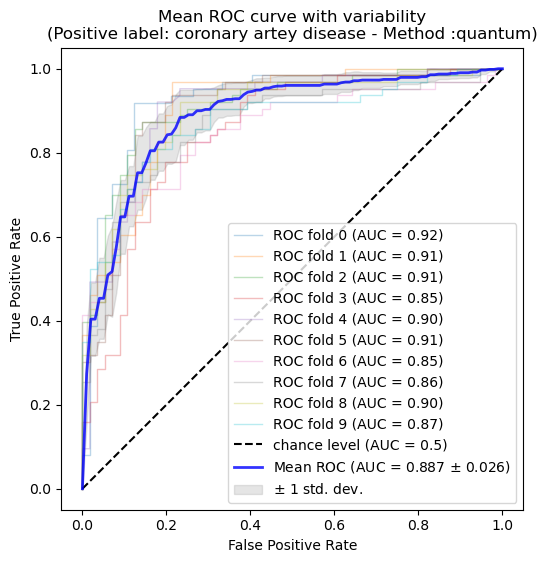

13:56


In [30]:
print(datetime.datetime.now().strftime("%H:%M"))
cross_val(heart_data, list_feature, 'target', kernel = zz_kernel.evaluate,
          method = "quantum", random_state = None, n_splits = 10)
print(datetime.datetime.now().strftime("%H:%M"))

##  11-qubit feature map for 11 features

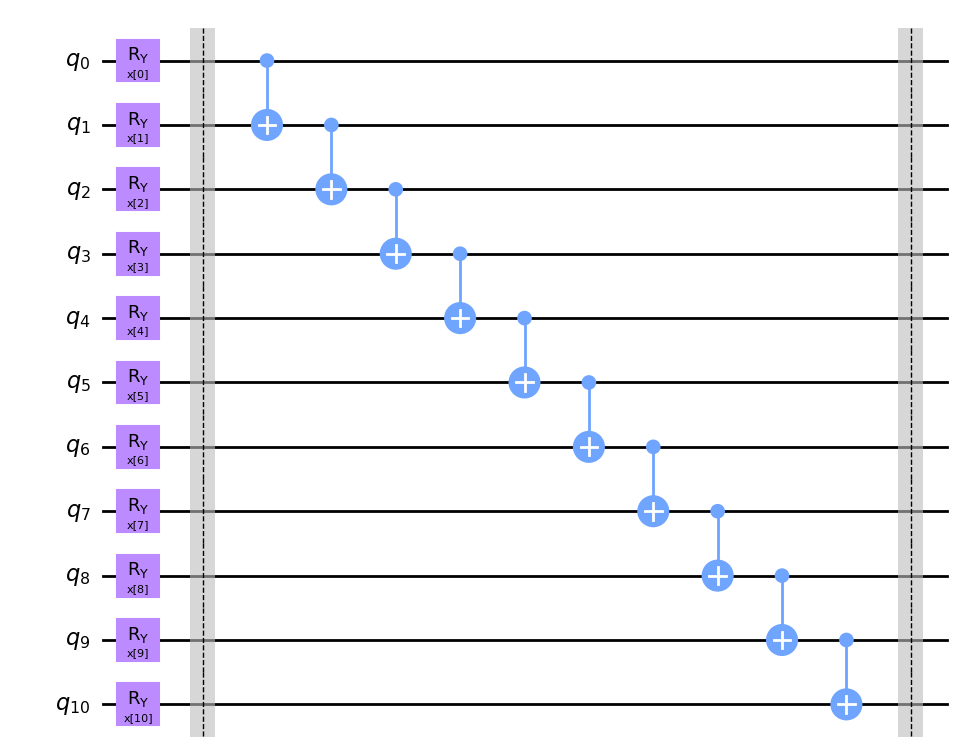

In [75]:
p1 = ParameterVector('x', 11)  
feature_map_11q = QuantumCircuit(11)
for i in range(11):
    feature_map_11q.ry(p1[i],i)
feature_map_11q.barrier()
for i in range(10):
    feature_map_11q.cx(i,i+1)
feature_map_11q.barrier()
feature_map_11q.draw(output="mpl")

In [76]:
zz_kernel_11q = QuantumKernel(feature_map=feature_map_11q, quantum_instance=Aer.get_backend('statevector_simulator'))

15:35
fold 0 starting
fold 1 starting
fold 2 starting
fold 3 starting
fold 4 starting
fold 5 starting
fold 6 starting
fold 7 starting
fold 8 starting
fold 9 starting


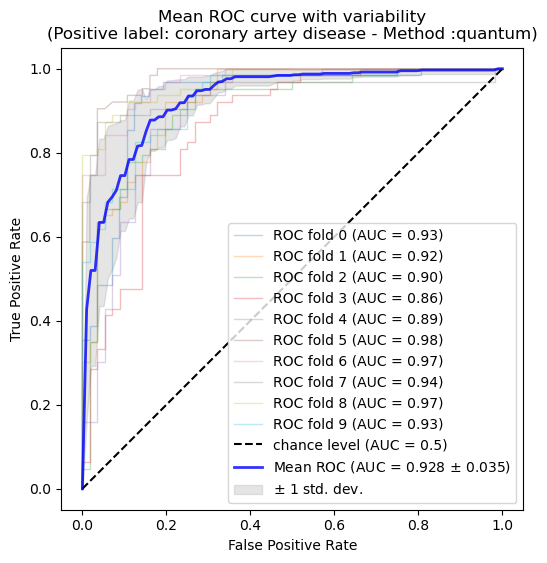

15:46


In [77]:
print(datetime.datetime.now().strftime("%H:%M"))
cross_val(heart_data, list_feature, 'target', kernel = zz_kernel_11q.evaluate,
          method = "quantum", random_state = None, n_splits = 10)
print(datetime.datetime.now().strftime("%H:%M"))

 ## Eight Feature Solution

In [78]:
# feature drop based on correlation coefficient vs target
list_feature_11 =  ['age', 'sex', 'chest pain type','fasting blood sugar',
                 'max heart rate','exercise angina', 'oldpeak', 'ST slope']      

## Classical

15:55
fold 0 starting
fold 1 starting
fold 2 starting
fold 3 starting
fold 4 starting
fold 5 starting
fold 6 starting
fold 7 starting
fold 8 starting
fold 9 starting


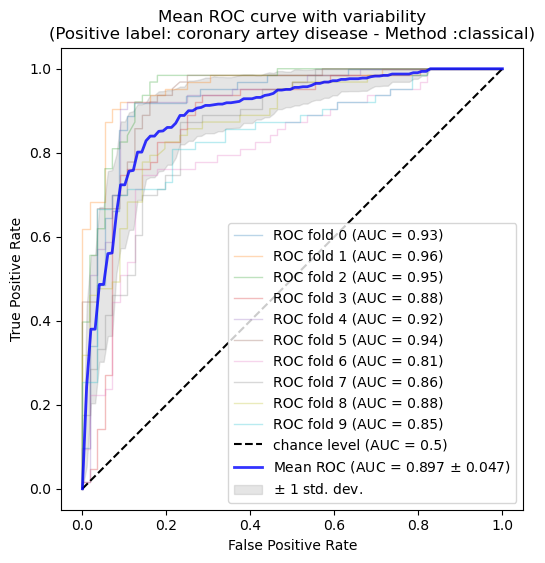

15:55


In [79]:
print(datetime.datetime.now().strftime("%H:%M"))
cross_val(heart_data, list_feature_11, 'target', kernel = "linear",
          method = "classical", random_state = None, n_splits = 10)
print(datetime.datetime.now().strftime("%H:%M"))

##  4-qubit feature map for 8 features

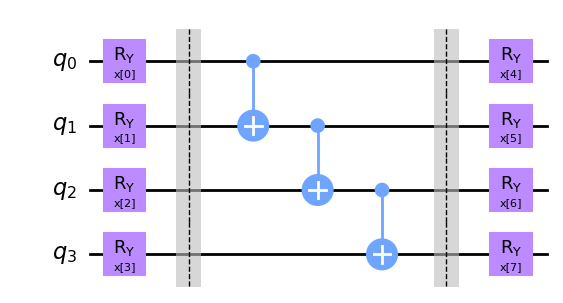

In [80]:
p1 = ParameterVector('x', 8)  
feature_map_8 = QuantumCircuit(4)
for i in range(4):
    feature_map_8.ry(p1[i],i)
feature_map_8.barrier()
for i in range(3):
    feature_map_8.cx(i,i+1)
feature_map_8.barrier()
for i in range(4):
    feature_map_8.ry(p1[i+4],i)
feature_map_8.draw(output="mpl")

In [81]:
zz_kernel_8 = QuantumKernel(feature_map=feature_map_8, quantum_instance=Aer.get_backend('statevector_simulator'))

15:55
fold 0 starting
fold 1 starting
fold 2 starting
fold 3 starting
fold 4 starting
fold 5 starting
fold 6 starting
fold 7 starting
fold 8 starting
fold 9 starting


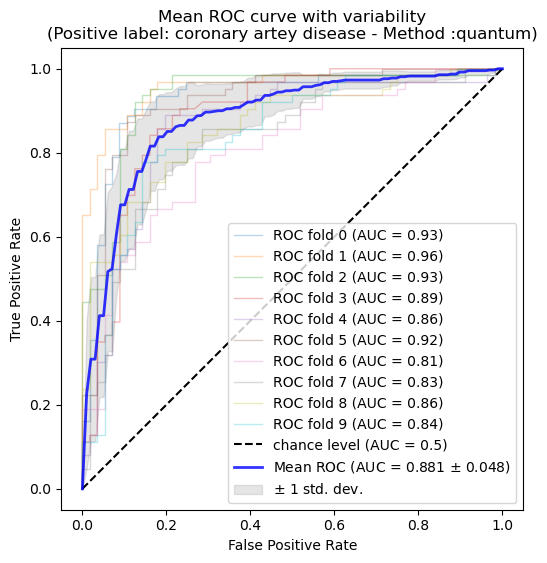

16:04


In [82]:
print(datetime.datetime.now().strftime("%H:%M"))
cross_val(heart_data, list_feature_11, 'target', kernel = zz_kernel_8.evaluate,
          method = "quantum", random_state = None, n_splits = 10)
print(datetime.datetime.now().strftime("%H:%M"))

##  8-qubit feature map for 8 features (better than 4-qubit map!)

Note: this circuit can probably be significantly impmroved for noisy system by judicious placing of cx gates

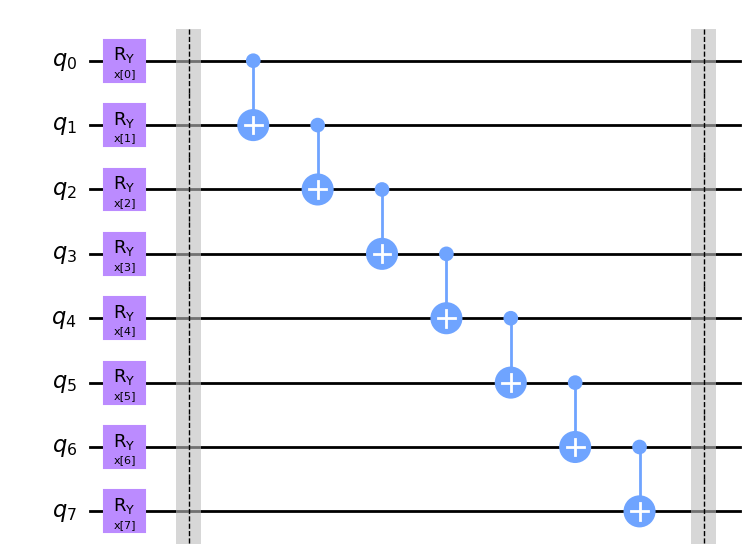

In [83]:
p1 = ParameterVector('x', 8)  
feature_map_8q = QuantumCircuit(8)
for i in range(8):
    feature_map_8q.ry(p1[i],i)
feature_map_8q.barrier()
for i in range(7):
    feature_map_8q.cx(i,i+1)
feature_map_8q.barrier()
feature_map_8q.draw(output="mpl")

In [84]:
zz_kernel_8q = QuantumKernel(feature_map=feature_map_8q, quantum_instance=Aer.get_backend('statevector_simulator'))

16:04
fold 0 starting
fold 1 starting
fold 2 starting
fold 3 starting
fold 4 starting
fold 5 starting
fold 6 starting
fold 7 starting
fold 8 starting
fold 9 starting


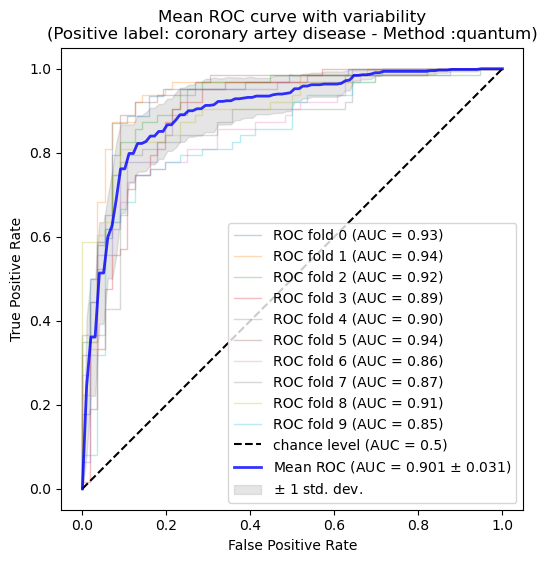

16:15


In [85]:
print(datetime.datetime.now().strftime("%H:%M"))
cross_val(heart_data, list_feature_11, 'target', kernel = zz_kernel_8q.evaluate,
          method = "quantum", random_state = None, n_splits = 10)
print(datetime.datetime.now().strftime("%H:%M"))